# EM casing response

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from multiprocessing import Pool
import pickle 
import os

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
# path_to_data = "/t40array/lheagy/casing-permeability"
path_to_data = "./tmp2"

In [3]:
save_figures = True
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [4]:
run_simulations = True
directory = f"{path_to_data}/fields_permeability"

if run_simulations is True: 
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 500

In [6]:
# diffusion distance
1260 * np.sqrt(1/sigma_back)

3984.469851812158

In [7]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0, 0.]

In [8]:
csz = 5
nabove = 3
npadz = 19
pf = 1.35

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=17,
    csx2=10,
    domain_x=return_electrode_r,
    pfx2=pf
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz+nabove), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz-nabove].sum()])
print(mesh.n_cells)

203040


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:307: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [9]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    # (1e-4, nt), (3e-4, nt), 
    # (1e-3, nt*2), (3e-3, nt*2+16),
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max()*1e3)

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back)):1.0f} m")

1.3200000000000012
diffusion distance 145 m


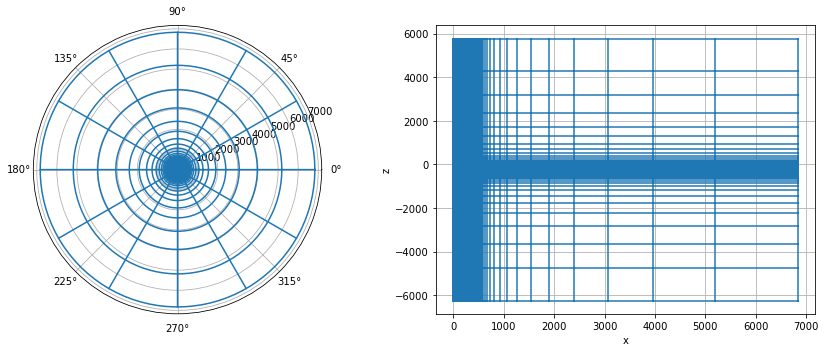

In [10]:
ax = mesh.plot_grid()

In [11]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z

In [12]:
mur_casing

array([  1,  50, 100, 150, 200])

In [13]:
halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

casing_conductivity = halfspace_conductivity.copy()
casing_conductivity[inds_casing] = sigma_casing

models = {}

models["halfspace"] = {
    "sigma": halfspace_conductivity, 
    "mur": np.ones(mesh.n_cells)
} 

for mur in mur_casing:
    key = f"casing_{mur:1.0f}"
    casing_mur = np.ones(mesh.n_cells)
    casing_mur[inds_casing] = mur
    # casing_permeability = casing_mur
    models[key] = {
        "sigma": casing_conductivity, 
        "mur": casing_mur
    }

# for mur in [200, sigma_casing]:
#     key = f"permeable_only_{mur:1.0f}"
#     casing_mur = np.ones(mesh.n_cells)
#     casing_mur[inds_casing] = mur
#     casing_permeability = casing_mur
#     models[key] = {
#         "sigma": halfspace_conductivity, 
#         "mur": casing_permeability
#     }
    

In [14]:
key = "mur"
np.any(models["halfspace"][key] - models["casing_1"][key])

False

In [15]:
def plot_casing(ax): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, casing_conductivity, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
    for sign in np.r_[-1, 1]: 
        ax.arrow(
            0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )

        ax.arrow(
            0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )
    ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
    ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [16]:
def plot_geometry(ax):
    survey_lim = (return_electrode_r + 70) * np.r_[-1, 1]
    norm = LogNorm(vmin=sigma_air, vmax=sigma_casing)
    cmap = colormap.get_cmap("Spectral_r")
    ax.set_facecolor(cmap(norm(sigma_back)))

    ax.plot(np.r_[0, return_electrode_r], np.r_[0, 0], color="k", marker="v")
    ax.plot(np.r_[0, 0], np.r_[0, survey_lim.max()], color="k", ls=":")
    ax.plot(0, 0, "o", color=cmap(norm(sigma_casing)), ms=8)

    ax.text(return_electrode_r/2, 10, "transmitter", ha="center")
    ax.text(0, -75, "casing", ha="center")
    ax.text(-5, survey_lim.max()/2, "receivers", ha="right")

    ax.set_xlim(survey_lim)
    ax.set_ylim(survey_lim)
    ax.set_aspect(1)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    return ax


In [17]:
from matplotlib import rcParams
rcParams["font.size"] = 16

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1017: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1051: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:148: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:264: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0 of di

Text(0.5, 1.0, '(b)')

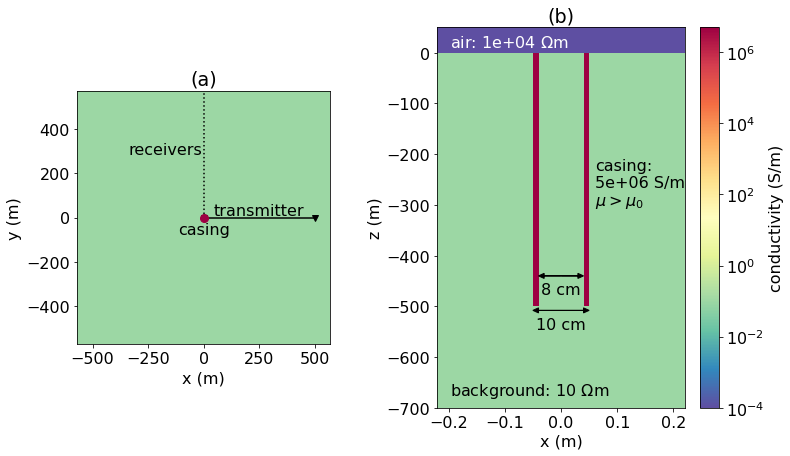

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 1.22], "wspace":0.38})

plot_geometry(ax[0])
plot_casing(ax[1])

ax[0].set_title("(a)")
ax[1].set_title("(b)")


# if save_figures:
#     fig.savefig(f"{fig_dir_high}/setup.png", dpi=dpi_high)
#     fig.savefig(f"{fig_dir_low}/setup.png", dpi=dpi_low)


## set up the simulations

In [19]:
# top casing source 
src_theta = mesh.h[1][0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)
src_locations

array([[ 4.87500000e-02,  2.61799388e-01, -2.50000000e+00],
       [ 4.87500000e-02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01, -2.50000000e+00]])

In [20]:
def generate_simulation(mur=1): 
    src = tdem.sources.LineCurrent([], location=src_locations)
    survey = tdem.Survey([src])
    sim = tdem.simulation.Simulation3DMagneticField(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, time_steps=time_steps, 
        mu=mur*mu_0
    )
    return sim


In [21]:
def load_fields(name, conductivity, mur):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, sim._fieldType + "Solution", :] = solution
    return f

In [22]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/times", times)
    
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [23]:
def run_simulation(key):
    t = time.time()
    print(f"starting {key}\n")
    sim = generate_simulation(models[key]["mur"])
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_{key}", f[:, f"{sim._fieldType}Solution", :])
    print(f" ... done {key}. {time.time()-t:1.2e} s")

In [25]:
models["casing_1"]["mur"].max()

1.0

In [24]:
# for key in models.keys():
#     run_simulation(key)
if run_simulations:   
    with Pool(6) as p:
        p.map(run_simulation, list(models.keys()))  

starting casing_1
starting halfspace
starting casing_100
starting casing_50
starting casing_150



starting casing_200





/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message

 ... done casing_150. 5.28e+02 s
 ... done casing_50. 5.38e+02 s
 ... done casing_100. 5.40e+02 s
 ... done casing_200. 5.44e+02 s
 ... done halfspace. 5.62e+02 s
 ... done casing_1. 5.65e+02 s


In [25]:
fields={}
for key in models.keys(): 
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [26]:
tind = 10
fields["halfspace"][:, "j", tind] - fields["casing_1"][:, "j", tind]

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1034: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:216: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


array([[-4.92728220e-12],
       [-4.89006626e-12],
       [-4.86783824e-12],
       ...,
       [ 6.27053332e-15],
       [ 5.47209324e-16],
       [ 6.33687160e-17]])

In [ ]:
# casing_permeability_mu_only = [200, int(sigma_casing)]
# keys_permeable_only = [f"permeable_only_{mur}" for mur in casing_permeability_mu_only]
# for key, mur in zip(keys_permeable_only, casing_permeability_mu_only):
#     fields[key] = run_simulation(key, mur)

In [ ]:
# for key, mur in zip(keys_permeable_only, casing_permeability_mu_only):
#     casing_mur = np.ones(mesh.n_cells)
#     casing_mur[inds_casing] = mur
#     mu = mu_0 * casing_mur
#     fields[key] = load_fields(key, halfspace_conductivity, mu)

In [27]:
fields["casing_1"][:, "j", 52]

array([[1.57691201e-10],
       [1.56500923e-10],
       [1.55790243e-10],
       ...,
       [1.51908549e-12],
       [2.76616685e-13],
       [1.81406806e-14]])

In [28]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    # 137,
    152,
    169,
    197,
    # 207,
    # 212,
    # 227,
    249,
    # 282,
] 
print(times[time_inds] * 1e3)

IndexError: index 152 is out of bounds for axis 0 with size 121

In [29]:
time_inds = [
    0,
    1, 
    2,
    3,
    4,
    5,
    10, 
    30, 
    # 53, 
    # # 78, 
    # 109,
    # # 137,
    # 152,
    # 169,
    # 197,
    # # 207,
    # # 212,
    # # 227,
    # 249,
    # # 282,
] 
print(times[time_inds] * 1e3)

[0.    0.001 0.002 0.003 0.004 0.005 0.01  0.03 ]


In [30]:
save_figures = False

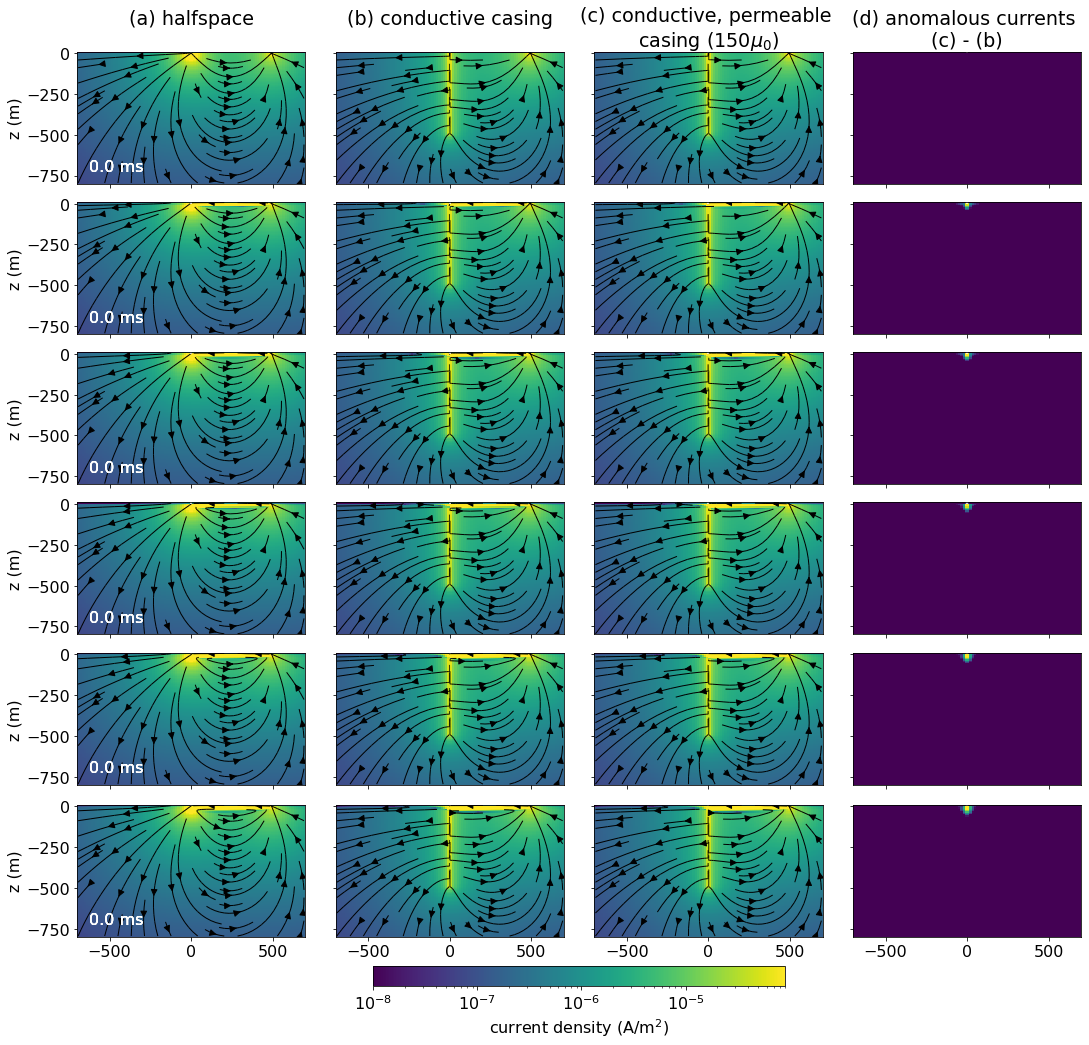

In [32]:
fig, ax = plt.subplots(
    len(time_inds)-2, 4, 
    figsize=(15, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

primary_key = "casing_1"
plot_keys = ["halfspace", "casing_1", "casing_150"] # "casing_150"]
for j, key in enumerate(plot_keys):
    f = fields[key]
    
    if key == plot_keys[-1]:
        primsec = ["total", "secondary"]
    else:
        primsec = ["total"]
    
    for i, ti in enumerate(time_inds[:-2]):
        for k, ps in enumerate(primsec): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                time_ind=ti,
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i,j+k], 
                clim=clim,
                show_cb=False,
                prim_sec=ps,
                primary_fields=fields[primary_key],
                stream_opts=stream_opts
            )
            ax[i, j+k].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, j+k].set_title("")
            if times[ti] < 2e-3: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
            else: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
            if i < len(time_inds)-1:
                ax[i, j+k].set_xlabel("")
            else:
                ax[i, j+k].set_xlabel("x (m)")
            if j > 0: 
                ax[i, j+k].set_ylabel("")
            else:
                ax[i, j+k].set_ylabel("z (m)")
            ax[i, j+k].set_aspect(1)
    
ax[0, 0].set_title("(a) halfspace\n")
ax[0, 1].set_title("(b) conductive casing\n")
ax[0, 2].set_title("(c) conductive, permeable \ncasing (150$\mu_0$)")
ax[0, 3].set_title("(d) anomalous currents \n(c) - (b)")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

KeyError: 'casing_150'

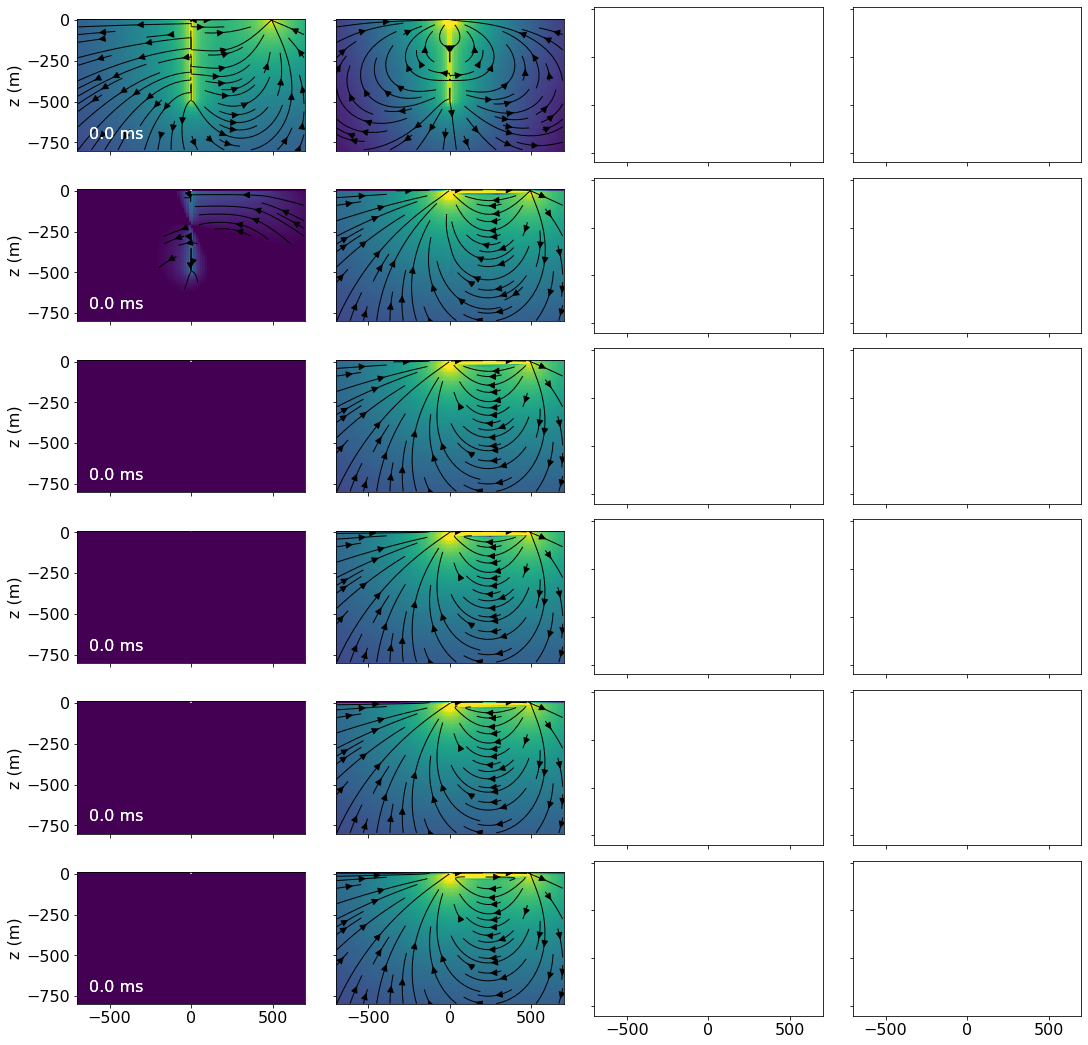

In [62]:
fig, ax = plt.subplots(
    len(time_inds)-2, 4, 
    figsize=(15, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

primary_key = "halfspace"
plot_keys = ["casing_1", "casing_150"]
jj = 0
for j, key in enumerate(plot_keys):
    f = fields[key]
    primsec = ["total", "secondary"]
    
    
    for k, ps in enumerate(primsec): 
        for i, ti in enumerate(time_inds[:-2]):
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                time_ind=ti,
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i,jj], 
                clim=clim,
                show_cb=False,
                prim_sec=ps,
                primary_fields=fields[primary_key],
                stream_opts=stream_opts
            )
            ax[i, jj].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, jj].set_title("")
            if times[ti] < 2e-3: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
            else: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
            if i < len(time_inds)-1:
                ax[i, jj].set_xlabel("")
            else:
                ax[i, jj].set_xlabel("x (m)")
            if jj > 0: 
                ax[i, jj].set_ylabel("")
            else:
                ax[i, jj].set_ylabel("z (m)")
            ax[i, jj].set_aspect(1)
        jj+=1
    
ax[0, 0].set_title("(a)\nconductive\n")
ax[0, 1].set_title("(b)\nconductive - halfspace\n")
ax[0, 2].set_title("(c)\nconductive, permeable \ncasing (150$\mu_0$)")
ax[0, 3].set_title("(d)\nconductive, permeable \n- halfspace")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

if save_figures: 
    pass
    # fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    # fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    2, len(time_inds),
    figsize=(len(time_inds)*2.2, 10),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.02}
)

xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-5, 1e2]

stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(["casing_1", "casing_150"]):
    f = fields[key]
    
    for j, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        
        if times[ti] < 2e-3: 
            ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
        else: 
            ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
        
        if i == 0:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.074])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fields.keys()

In [ ]:
Icc = {}

for key, val in fields.items():
    print(key)
    Icc[key] = mesh.average_face_to_cell_vector * (
        discretize.utils.sdiag(mesh.area) * val[:, "j", :]
    )

In [ ]:
Icc_cart = {}

for key, val in Icc.items():
    print(key)
    Icc_cart[key] = np.stack([
        discretize.utils.cylindrical_to_cartesian(
            mesh.gridCC, val[:, i]
        )
        for i in range(val.shape[-1])
    ], axis=-1)

In [ ]:
Icc_cart["halfspace"].shape

In [ ]:
test_x = np.r_[50, 100]
test_x_inds = (mesh.gridCC[:, 0] > test_x.min()) & (mesh.gridCC[:, 0] < test_x.max())

test_theta = np.r_[0, 3, 6]
test_theta_inds = [
    (mesh.gridCC[:, 1] == mesh.cell_centers_y[i]) for i in test_theta
]

test_depths = [np.r_[75, 125], np.r_[225, 275], np.r_[375, 425]]
test_z_inds = [
    (mesh.gridCC[:, 2] > -d.max()) & (mesh.gridCC[:, 2] < -d.min())
    for d in test_depths
]

In [ ]:
key = "halfspace"
thetai = test_theta_inds[0]
depthi = test_z_inds[0]
inds = test_x_inds & thetai & depthi
Icc_cart["halfspace"][inds, :, :].sum(0).shape

In [ ]:
e_avg = {}
for key, val in Icc_cart.items():
    tmp = np.zeros((len(test_theta_inds), len(test_z_inds), len(times)))
    for i, thetai in enumerate(test_theta_inds):
        for j, depthi in enumerate(test_z_inds): 
            inds = test_x_inds & thetai & depthi
            Icc_total = (
                (Icc_cart[key])[inds, :, :].sum(0)
            )
            Icc_amplitude = np.sqrt((Icc_total**2).sum(0))
            Ecc = (Icc_amplitude / mesh.vol[inds].sum()) / sigma_back
            tmp[i, j, :] = Ecc
    e_avg[key] = tmp
            

In [ ]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=False)
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            ax[j, i].loglog(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i].set_title(
                f"$\\theta$={(mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi:1.0f}$^\circ$, depth={np.mean(depthi):1.0f}m"
            )
            ax[j, i].grid("both")
            ax[j, i].set_xlim([1e-1, 2e2])
            ax[j, i].set_ylim([1e-9, 3e-5])

for a in ax[2, :].flatten():
    a.set_xlabel("time (ms)")
    
ax[0, 0].legend()

plt.tight_layout()
            

In [ ]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(2, 4, figsize=(17, 7), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})

primary_key = "casing_1"
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] / e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            if key in primary_key:
                ax[j, 0].loglog(
                    times*1e3, e_avg[key][i, jj, :], color="k", 
                    ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$"
                )
                ax[j, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
            ax[j, i+1].semilogx(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i+1].set_title(
                f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])
# ax[0, 0].set_ylim([0, 25])

for a in ax[-1, :].flatten():
    a.set_xlabel("time (ms)")

for a in ax[:, 0]:
    a.set_ylim([2e-10, 2e-5])
    a.set_ylabel("|E|")

for a in ax[:, 1]:
    a.set_ylabel("|E| / |E($\mu_0$)|")

for a in ax[:, 1:].flatten():
    tmp = a.get_ylim()
    a.set_ylim([0, tmp[1]])

ax[0, 1].legend()
ax[0, 0].legend()

plt.tight_layout()
            
# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/excitation-time", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/excitation-time", dpi=dpi_low, bbox_inches="tight")

In [ ]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1.3, 1, 1, 1]})

primary_key = "casing_1"
focus_key = "casing_150"
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] / e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            if key == primary_key or key == focus_key:
                ax[j, 0].loglog(
                    times*1e3, e_avg[key][i, jj, :], color="k" if key==primary_key else f"C{k}", 
                    ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$" if key==primary_key else None
                )
                ax[j, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
            ax[j, i+1].semilogx(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i+1].set_title(
                f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])
# ax[0, 0].set_ylim([0, 25])

for a in ax[-1, :].flatten():
    a.set_xlabel("time (ms)")

for a in ax[:, 0]:
    a.set_ylim([2e-10, 2e-5])
    a.set_ylabel("|E|")

for a in ax[:, 1]:
    a.set_ylabel("|E| / |E($\mu_0$)|")

for a in ax[:, 1:].flatten():
    tmp = a.get_ylim()
    a.set_ylim([0, tmp[1]])

ax[0, 1].legend()
ax[0, 0].legend()

plt.tight_layout()
            
if save_figures: 
    fig.savefig(f"{fig_dir_high}/excitation-time", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/excitation-time", dpi=dpi_low, bbox_inches="tight")

In [ ]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(4, 3, figsize=(16, 14), sharex=True, sharey=False)

primary_key = "casing_1"
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_avg.keys())[1:]):
    total = e_avg[key]
    difference = e_avg[key] - e_avg[primary_key]
    ratio =  total / e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            ax[j*2, 0].loglog(
                times*1e3, difference[i, jj, :], color=f"C{k}", 
                # ls=linestyles[i] #, label=f"$\\theta$={theta_label:1.0f}$^\circ$"
                label=label
            )
            ax[j*2, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
                # if key == focus_key:
                #     ax[j, 0].loglog(
                #         times*1e3, e_avg[key][i, jj, :] - e_avg[primary_key][i, jj, :], color=f"k", 
                #         ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$"
                #     ) 
            # ax[j*2+1, 1].semilogx(times*1e3, ratio[i, jj, :], color=f"C{k}", label=label)
            # ax[j*2+1, 1].set_title(
            #     f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            # )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])
# # ax[0, 0].set_ylim([0, 25])

# for a in ax[-1, :].flatten():
#     a.set_xlabel("time (ms)")

# for a in ax[:, 0]:
#     a.set_ylim([2e-10, 2e-5])
#     a.set_ylabel("|E$_p$|")

# for a in ax[:, 1]:
#     a.set_ylabel("|E$_p$| / |E$_p$($\mu_0$)|")

# for a in ax[:, 1:].flatten():
#     tmp = a.get_ylim()
#     a.set_ylim([0, tmp[1]])

# ax[0, 1].legend()
# ax[0, 0].legend()

plt.tight_layout()
            
# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/excitation-time", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/excitation-time", dpi=dpi_low, bbox_inches="tight")

In [ ]:
test_depth_inds = np.r_[0, 2]
primary_key = "casing_1"
fig, ax = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=False)
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] - e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            ax[j, i].loglog(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i].set_title(
                f"$\\theta$={(mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi:1.0f}$^\circ$, depth={np.mean(depthi):1.0f}m"
            )
            ax[j, i].grid("both")
            ax[j, i].set_xlim([1e-1, 2e2])
            ax[j, i].set_ylim([1e-9, 3e-5])

for a in ax[2, :].flatten():
    a.set_xlabel("time (ms)")
    
ax[0, 0].legend()

plt.tight_layout()
            

In [ ]:
# def get_casing_currents(j):

#     casing_faces_x = (
#         (mesh.gridFx[:, 0] >= casing_a) &
#         (mesh.gridFx[:, 0] <= casing_b) &
#         (mesh.gridFx[:, 2] <= 0) &
#         (mesh.gridFx[:, 2] >= -casing_l)
#     )
#     casing_faces_y = np.zeros(mesh.n_faces_y, dtype=bool)
#     casing_faces_z = (
#         (mesh.gridFz[:, 0] >= casing_a) &
#         (mesh.gridFz[:, 0] <= casing_b) &
#         (mesh.gridFz[:, 2] <= 0) &
#         (mesh.gridFz[:, 2] >= -casing_l)
#     )

#     casing_face_inds = discretize.utils.sdiag(
#         np.hstack([casing_faces_x, casing_faces_y, casing_faces_z])
#     )

#     casing_currents = casing_face_inds * (mesh.face_areas[:, None] * j)

#     casing_current_x = casing_currents[:mesh.n_faces_x, :].reshape(
#         mesh.vnFx[0], mesh.vnFx[1], mesh.vnFx[2], len(sim.times), order='F'
#     )
#     casing_current_z = casing_currents[mesh.nFx + mesh.nFy:, :].reshape(
#         mesh.vnFz[0], mesh.vnFz[1], mesh.vnFz[2], len(sim.times), order='F'
#     )

#     x = {}
#     x["leakage"] = casing_current_x
#     x["total"] = casing_current_x.sum(0).sum(0)
#     x["magnitude"] = np.abs(casing_current_x).sum(0).sum(0)
#     x["positive"] = ((casing_current_x > 0) * casing_current_x).sum(0).sum(0)
#     x["negative"] = ((casing_current_x < 0) * casing_current_x).sum(0).sum(0)
    

#     z = {}
#     z["total"] = casing_current_z.sum(0).sum(0)
#     z["magnitude"] = np.abs(casing_current_z).sum(0).sum(0)
#     z["positive"] = ((casing_current_z > 0) * casing_current_z).sum(0).sum(0)
#     z["negative"] = ((casing_current_z < 0) * casing_current_z).sum(0).sum(0)
    

#     return {"x":x, "z":z}



In [ ]:
# integrated_currents = {}
# for key, val in fields.items():
#     integrated_currents[key] = get_casing_currents(val[:, "j", :])

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 12))
# mur = 1
# for j, k in enumerate([key for key in list(integrated_currents[f"casing_{mur}"]["z"].keys()) if key != "magnitude"]):
#     ax[j].plot(
#         mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"][k][:, 0::20], color=f"k", alpha=0.4, label=f"{mur} $\mu_0$"
#     );
#     ax[j].set_xlim(0, -50)

#     ax[j].grid()
#     ax[j].set_title(k)

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(8, 12))
# mur = 1
# for j, k in enumerate([key for key in list(integrated_currents[f"casing_{mur}"]["x"].keys()) if key != "magnitude"]):
#     ax[j].plot(
#         mesh.vectorCCz, integrated_currents[f"casing_{mur}"]["x"][k][:, 0::20], color=f"k", alpha=0.4, label=f"{mur} $\mu_0$"
#     );
#     ax[j].set_xlim(0, -50)

#     ax[j].grid()
#     ax[j].set_title(k)

In [ ]:
# time_inds_currents = time_inds[-1]

In [ ]:
# fig, ax = plt.subplots(4, 1, figsize=(8, 12))

# for j, k in enumerate(integrated_currents[f"casing_1"]["z"].keys()):
#     for i, mur in enumerate(mur_casing):
#         ax[j].plot(
#             mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"][k][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
#         );
#         ax[j].set_xlim(0, -casing_l)

#     ax[j].grid()
#     ax[j].set_title(k)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# tind = time_inds[-2]
# for i, mur in enumerate(mur_casing):
#     ax.plot(
#         mesh.vectorCCz, integrated_currents[f"casing_{mur}"]["x"]["total"][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
#     );
#     ax.set_xlim(0, -casing_l)

# ax.grid()

In [ ]:
# integrated_currents[f"casing_{mur}"]["z"]["positive"]

In [ ]:
# fig, ax = plt.subplots(1, 1)

# ax.plot(
#     mesh.vectorNz, integrated_currents[f"casing_{mur}"]["z"]["positive"][:, time_inds_currents], color=f"C{i}", alpha=0.7, label=f"{mur} $\mu_0$"
# );
# ax.set_xlim(0, -casing_l)


In [ ]:
# times[time_inds]

In [ ]:
plot_spatial = {}

for model_type in ["casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for ti in time_inds:
        primary = discretize.utils.mkvc(fields[f"casing_1"][:,'e', ti])
        total = discretize.utils.mkvc(fields[f"{model_type}"][:,'e', ti])
        tmp[ti] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_spatial[model_type] = tmp

In [ ]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", color=None, label=None, invert_axes=False):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end] 
                
            if np.all(yvals <= 0):
                if invert_axes is True:
                    getattr(ax, plot_type)(np.abs(yvals), xvals, "--", color=color)
                else: 
                    getattr(ax, plot_type)(xvals, np.abs(yvals), "--", color=color)
            else: 
                if invert_axes is True: 
                    getattr(ax, plot_type)(yvals, xvals, "-", color=color, label=label)
                else:
                    getattr(ax, plot_type)(xvals, yvals, "-", color=color, label=label)
                label=None
        return ax

In [ ]:
theta_loc=5

In [ ]:
plot_spatial["casing_1"].keys()

In [ ]:
def plot_spatial_data(plot_spatial, ax, tind, xlim=None, ylim=None, percent_lim=None, labels=True, legend=True, plot_diff=True):
    zloc = -csz/2
    face_inds_plotting = np.hstack([
        ((mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
         (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))),
        np.zeros(mesh.n_faces_y, dtype=bool), np.zeros(mesh.n_faces_z, dtype=bool)
    ])
    
    for i, key in enumerate(list(plot_spatial.keys())):
        val = plot_spatial[key][tind]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        plot_pos_neg_log(mesh.nodes_x[1:], val["total"][face_inds_plotting].squeeze(), ax[0], "semilogy", label=legend, color=f"C{i}") 
        if plot_diff: 
            plot_pos_neg_log(mesh.nodes_x[1:], val["difference"][face_inds_plotting], ax[1], "semilogy", label=legend, color=f"C{i}")
            plot_pos_neg_log(mesh.nodes_x[1:], val["percent"][face_inds_plotting], ax[2], "semilogy", label=legend, color=f"C{i}")

    
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(percent_lim)
    
    if labels is True: 
        ax[0].set_ylabel("Amplitude (V/m)")
        ax[1].set_ylabel("Difference (V/m)")
        ax[2].set_ylabel("Difference (%)")
    
    if legend is True:
        ax[0].legend()
    ax[2].set_xlabel("x (m)")

    for a in ax.flatten():
        a.grid("both", alpha=0.6)
        a.set_xlim(xlim)
    
    return ax



In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 11.5), sharex=True)
time_inds_plot = [197]

xlim = np.r_[0, 500]
ylim = np.r_[1e-9, 1e-3]
ylim_percent = np.r_[1e1, 3e4]

plot_spatial_data(plot_spatial, ax, time_inds_plot[0], xlim=xlim, ylim=ylim, percent_lim=ylim_percent)

In [ ]:
fig, ax = plt.subplots(
    len(time_inds)-2, 3, 
    figsize=(15, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=False, sharey=False, 
    # gridspec_kw={"hspace":0.07,"wspace":0.1}
)

fields_key = "casing_200"
primary_key="casing_1"

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[3e-8, 6e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1} 
ylim = np.r_[1e-8, 1e-3]
ylim_percent = np.r_[3e-2, 3e3]
    
for i, ti in enumerate(time_inds[:-2]): 
    plot_spatial_data(plot_spatial, ax[i, :], ti, xlim=np.r_[0, 600], ylim=ylim, percent_lim=ylim_percent, plot_diff=False if i < 1 else True)
    if times[ti] < 2e-3: 
        ax[i, 0].text(590, 1e-4, f"{times[ti]*1e3:1.1f} ms", color="k", ha="right", fontsize=16)
    else: 
        ax[i, 0].text(590, 1e-4, f"{times[ti]*1e3:1.0f} ms", color="k", ha="right", fontsize=16)

# hack to get the legend
for i, mur in enumerate(mur_casing):
    ax[0, 2].plot(np.r_[0, 0], np.r_[0, 0], f"C{i}", label=f"{mur} $\mu_0$")
# ax[0, 1].set_xlim([100, 200])
# ax[0, 2].set_xlim([100, 200])
ax[0, 1].axis("off")
ax[0, 2].axis("off")
ax[0, 2].legend()

ax[0, 0].set_title("(a) Total E")
ax[1, 1].set_title("(b) Difference from casing with $\mu_0$")
ax[1, 2].set_title("(c) Difference as percent")

if save_figures:
    pass
    # fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    # fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
times[time_inds[2]]*1e3

In [ ]:
mesh.cell_centers_z[50]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={"hspace":0.09,"wspace":0.01})
key = "casing_1"
f = fields[key]
xlim=800*np.r_[-1, 1]

zind = 118
clim = np.r_[3e-8, 1e-4]

stream_opts={"color":"k", "density":0.8, "arrowsize":1.4, "linewidth":1.5}
for a, key, primsec in zip(ax, ["casing_1", "halfspace", "casing_1"], ["total", "total", "secondary"]): 
    out = casing_sim.view.plot_depth_slice(
        fields[key],
        view="j",
        primary_fields=fields["halfspace"],
        prim_sec=primsec,
        time_ind=time_inds[2],
        xlim=xlim,
        ylim=xlim,
        z_ind=zind, 
        theta_shift=0.5*mesh.hy[0],
        ax=a, 
        clim=clim,
        show_cb=False,
        k=40,
        # component="xz",
        stream_opts=stream_opts
    )
    a.set_title("")
    a.set_aspect(1)
    a.set_xlabel("x (m)")
    
    if a == ax[0]:
        a.set_ylabel("y (m)")
    else:
        a.set_ylabel("")
        a.set_yticklabels("")
    
cb = plt.colorbar(out[0], ax=ax[-1]) 
cb.set_label("current density (A/m$^2$)")

ax[0].set_title("(a) conductive casing")
ax[1].set_title("(b) halfspace")
ax[2].set_title("(c) difference")

if save_figures: 
    fig.savefig(f"{fig_dir_high}/currents-depth-slice", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/currents-depth-slice", dpi=dpi_low, bbox_inches="tight")

In [ ]:
def add_circle(ax, radius, color="k", ls="-"):
    x = np.linspace(-radius, radius, 100)
    top = np.sqrt(radius**2 - x**2)
    ax.plot(x, top, color=color, ls=ls)
    ax.plot(x, -top, color=color, ls=ls)

In [ ]:
fig, ax = plt.subplots(1, 1)
xlim = 0.075 * np.r_[-1, 1]
zind = 97
out = casing_sim.view.plot_depth_slice(
    fields["casing_1"],
    view="dbdt",
    primary_fields=fields["casing_1"],
    prim_sec=total,
    time_ind=time_inds[4],
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax, 
    clim=np.r_[1e-7, 1e-2],
    show_cb=False,
    k=3,
    # component="y",
    stream_opts=stream_opts
    )
# ax.set_title("")
ax.set_aspect(1)
plt.colorbar(out[0], ax=ax)

In [ ]:
tinds_plot = [109, 169]
times[tinds_plot]*1e3

In [ ]:
xlocs = np.r_[60]
mesh.vectorNx[xlocs]

In [ ]:
zloc = -csz/2
theta_loc = 6

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
    )[0]
    print(mesh.faces_x[face_inds[i], :])

In [ ]:
plot_timeseries = {}

for model_type in ["halfspace", "casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for fi in face_inds:
        tmp[fi] = (discretize.utils.mkvc(fields[f"{model_type}"][:,'e', :][fi, :]))
    plot_timeseries[model_type] = tmp

In [ ]:
def plot_time_data(val, ax, color_ind=None, xlim=None, ylim=None, percent_lim=None, labels=True, legend=True):
    legend = f"{key.split('_')[-1]} $\mu_0$"
    ax[0].loglog(times*1e3, np.abs(val["total"]), label=legend, color=f"C{color_ind}")
    ax[1].loglog(times*1e3, np.abs(val["difference"]), color=f"C{color_ind}")
    ax[2].loglog(times*1e3, np.abs(val["percent"]), color=f"C{color_ind}")

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(percent_lim)

    if labels is True: 
        ax[0].set_ylabel("electric field Amplitude (V/m)")
        ax[1].set_ylabel("Difference (V/m)")
        ax[2].set_ylabel("Difference (%)")
    
    if legend is True: 
        ax[0].legend(loc=3)
    ax[2].set_xlabel("time (ms)")
    for a in ax.flatten(): 
        a.grid("both", alpha=0.6)
        a.set_xlim(xlim)

    
    return ax

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
fields["casing_1"].simulation.mu.max()

In [ ]:
plot_timeseries.keys()

In [ ]:
rcParams["font.size"]=14

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 
fi = 0

for i, k in enumerate(list(plot_timeseries.keys())[1:]):
    val = plot_timeseries[k][face_inds[fi]]
    legend = f"{k.split('_')[-1]} $\mu_0$"
    plot_pos_neg_log(times*1e3, val, ax, plot_type="loglog", color=f"C{i}", label=legend)

# lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(mur_casing))]
ax.grid("both", alpha=0.8)
ax.set_xlim(np.r_[1e-2, 3e2])
ax.set_ylim(np.r_[1e-10, 2e-4])
ax.set_xlabel("time (ms)")
ax.legend()

ax.set_ylabel("e$_r$ (V/m)")

if save_figures:
    fig.savefig(f"{fig_dir_high}/e-fields-tdem.png", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/e-fields-tdem.png", dpi=dpi_low, bbox_inches="tight")

In [ ]:
# zloc = 0
# theta_loc = 0

# edge_inds = np.zeros_like(xlocs)

# for i, xl in enumerate(xlocs):
#     edge_inds[i] = np.where(
#         (mesh.edges_y[:, 0] == mesh.nodes_x[xl]) &
#         (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_loc]) & 
#         (mesh.edges_y[:, 2] == zloc)
#     )[0] + mesh.n_edges_x

In [ ]:
# plot_timeseries_dbdt = {}

# primary_key = "casing_1"

# for model_type in ["casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
#     print(model_type)
#     tmp = {}
#     for ei in edge_inds:
#         total = (discretize.utils.mkvc(fields[f"{model_type}"][:,'dbdt', :][ei, :]))
#         if model_type == primary_key: 
#             primary = total
#         else: 
#             primary = plot_timeseries_dbdt[primary_key][ei]["total"]
        
#         tmp[ei] = {
#             "total":total, 
#             "primary":primary,
#             "difference":total - primary,
#             "percent":(total - primary)/np.abs(primary) * 100
#         }
#     plot_timeseries_dbdt[model_type] = tmp

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(7, 11.5), sharex=True)

# edge_ind = 3
# xlim = np.r_[1e-1, 1e3]

# view_key = "total" 

# for i, key in enumerate(plot_timeseries_dbdt.keys()):
#     val = plot_timeseries_dbdt[key]
#     legend = f"{key.split('_')[-1]} $\mu_0$"
#     ax[0].loglog(times*1e3, np.abs(val[edge_inds[edge_ind]]["total"]), label=key, color=f"C{i}")
#     ax[1].loglog(times*1e3, np.abs(val[edge_inds[edge_ind]]["difference"]), label=key, color=f"C{i}")
#     ax[2].loglog(times*1e3, np.abs(val[edge_inds[edge_ind]]["percent"]), label=key, color=f"C{i}")


# ax[0].set_xlim(1e-2, 1e3)
# ax[0].set_ylim([1e-13, 1e-4])
# ax[1].set_ylim([1e-13, 1e-8])
# ax[2].set_ylim([1e-3, 2e1])
# ax[0].legend()

# for a in ax:
#     a.grid("both", alpha=0.6)

In [ ]:
# cell_centered_dbdt = {}
# cell_centered_e = {}
# cell_centered_b = {}

In [ ]:
for key, val in fields.items():
    if key not in cell_centered_dbdt.keys():
        cell_centered_dbdt[key] = mesh.average_edge_to_cell_vector * val[:, "dbdt", :]

In [ ]:
for key, val in fields.items():
    if key not in cell_centered_e.keys():
        cell_centered_e[key] = mesh.average_face_to_cell_vector * val[:, "e", :]

In [ ]:
for key, val in fields.items():
    if key not in cell_centered_b.keys():
        cell_centered_b[key] = mesh.average_edge_to_cell_vector * val[:, "b", :]

In [ ]:
tinds_plot = [0, 109] #, 197]
print(times[tinds_plot] * 1e3)

In [ ]:
fig, ax = plt.subplots(3, len(tinds_plot)+3,figsize=(18, 10), gridspec_kw={"width_ratios": [1, 1, 0.15, 2.2, 2.2], "wspace":0.25})
zind = 118
fi = face_inds[1]

key = "casing_200"
f = fields[key]
xlim=600*np.r_[-1, 1]
stream_opts={"color":"k", "density":0.6}

tlim = np.r_[2e-1, 3e2]
ylim = np.r_[6e-11, 3e-4]
percent_lim = [1, 5e4]

for a in np.hstack([ax[2, 0:2], ax[:, 2]]):
    a.axis("off")

for i, tind in enumerate(tinds_plot):
    for j, view in enumerate(["total", "secondary"]):
        out = casing_sim.view.plot_depth_slice(
            f, view="e", time_ind=tind,
            primary_fields=fields["casing_1"], prim_sec=view,
            xlim=xlim, ylim=xlim, z_ind=zind, 
            theta_shift=0.5*mesh.hy[0],
            ax=ax[j, i], 
            clim=np.r_[2e-8, 1e-3],
            show_cb=False,
            k=30,
            component="vec",
            stream_opts=stream_opts
        )
        ax[j, i].set_aspect(1)
        ax[j, i].set_title("")
        
        if j>0:
            ax[j, i].set_xlabel("x (m)")
            if i>0:
                cb = plt.colorbar(out[0], ax=ax[j+1, 0:2], orientation="horizontal", shrink=0.7, anchor=(0.5, 10))
                cb.set_label("Electric field (V/m)")
        else: 
            ax[j, i].set_title(f"({ascii_lowercase[i]}) t={times[tind]*1e3:1.0f}ms")
            ax[j, i].set_xlabel("")
            ax[j, i].set_xticklabels("")
            
        if i>0: 
            ax[j, i].set_ylabel("")
            ax[j, i].set_yticklabels("")
        else: 
            ax[j, i].set_ylabel("y (m)")
            
        ax[j, i].plot(np.r_[0, 0], np.r_[0, xlim.max()], 'w--')
        ax[j, i].plot(np.r_[0], np.r_[mesh.faces_x[fi, 0]], "ro")

for a in ax[:, 3]:
    a.axvline(mesh.faces_x[fi, 0], ls="--", color="k", alpha=0.7)
    
plot_spatial_data(
    plot_spatial, ax[:, 3], tinds_plot[1], xlim=np.r_[0.01, xlim.max()], ylim=ylim, 
    percent_lim=percent_lim, labels=True, legend=False
)

    
ax[0, 3].set_title(f"(c) t={times[tinds_plot[1]]*1e3:1.0f} ms")

for a in ax[:, 4]:
    a.axvline(times[tinds_plot[1]]*1e3, ls="--", color="k", alpha=0.7)
    
for i, key in enumerate(list(plot_timeseries.keys())[1:]):
    val = plot_timeseries[key][fi]
    plot_time_data(val, ax[:, 4], color_ind=i, xlim=tlim, ylim=ylim, percent_lim=percent_lim, labels=False, legend=True)
    ax[0, 4].set_title(f"(d) y={mesh.faces_x[fi, 0]:1.0f} m")
    
for a in ax[0:-1, 3:].flatten():
    a.set_xticklabels("")
    
for a in ax[:, 4].flatten():
    a.set_yticklabels("")
    
ax[0, 4].legend()


if save_figures:
    fig.savefig(f"{fig_dir_high}/e-fields-data-time.png", dpi=dpi_high)
    fig.savefig(f"{fig_dir_low}/e-fields-data-time.png", dpi=dpi_low)
            

In [ ]:
theta_ind=0
tind_plot=time_inds[2]

def plot_cross_section_field(
    key, field, time_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    prime_sec="total", primary_key=None, 
    log_scale=False, eps=1e-15, vmin=None, clim=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
        
    field_plot = ave * fields[key][:, field, time_ind]
    
    if prime_sec in ["secondary", "percent", "primary"]:
        if primary_key is None: 
            primary_key = get_primary_key(key)
        primary = ave * fields[primary_key][:, field, time_ind]
        if prime_sec == "primary": 
            field_plot = primary
        else: 
            field_plot = field_plot - primary
            if prime_sec == "percent":
                field_plot = dfield_plot / np.abs(primary + eps) * 100

    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind, :]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror, :]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    # plot x,z vector
    fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
    fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

    sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

    vmax = clim.max() if clim is not None else None
    if log_scale is True: 
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else: 
        norm = Normalize(0, vmax)
    out = mesh2d.plot_image(
        fieldxz, v_type="CCv", view="vec", ax=ax[0],
        range_x=xlim, range_y=zlim,
        sample_grid=sample_grid,
        mirror=True, mirror_data=fieldxz_mirror,
        pcolor_opts={"norm":norm},
        stream_threshold=vmin,
    )
    plt.colorbar(out[0], ax=ax[0])

    
    pcolor_optsy = {"cmap":"Spectral_r"}
    linthresh = vmin if vmin is not None else eps
    
    if clim is None: 
        # vmin, vmax = np.max(np.abs(
        #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
        # ))*np.r_[-1, 1]
        vmin, vmax = norm.vmax*np.r_[-1, 1]
    else: 
        vmin = np.min(clim)
        vmax = np.max(clim)
        
    if log_scale is True:
        pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
    else: 
        pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    
    out2 = mesh2d.plot_image(
        field_components["y"]["data"], ax=ax[1],
        mirror=True, mirror_data=field_components["y"]["mirror"],
        range_x=xlim, range_y=zlim, 
        pcolor_opts=pcolor_optsy
    )
    plt.colorbar(out2[0], ax=ax[1])
    return ax

In [ ]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    137,
    # 152,
    169,
    # 171,
    # 175,
    # 179,
    # 182,
    # 187,
    197,
] 
print(times[time_inds] * 1e3)

In [ ]:
fields.keys()

In [ ]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "e", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="total", 
        log_scale=True,
        # clim=1e-3*np.r_[-1, 1],
        vmin=1e-7
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

# key = "permeable_only_5000000.0"
# primary_key = "halfspace"


for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "j", time_ind=ti, theta_ind=0, ax=ax[i,:], 
        xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="total",
        clim=1e-4*np.r_[-1, 1],
        log_scale=True,
        vmin=1e-10
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

# key = "casing_1"
# primary_key = None #"mu_1_target_1e-01"

key = "casing_200"
primary_key = "casing_1" 

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "dbdt", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-11,
        clim=1e-8*np.r_[-1, 1]
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

# key = "permeable_only_5000000.0"
# primary_key = "halfspace"

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "b", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-10,
        clim=1e-11*np.r_[-1, 1]
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 5))
# key = "permeable_only_5000000.0"
# casing_sim.view.plot_slice(
#     mesh, fields[key].simulation.sigma, ax=ax,
# )
# ax.set_xlim(0.1 * np.r_[-1, 1])
# ax.set_ylim(np.r_[-700, 50])

In [ ]:
def plot_cell_centered_data_time(
    fcc, ax, ind, keys=list(cell_centered_e.keys())[:-1], primary_key="casing_1", 
    xlim=None, ylim=None, percent_lim=None, eps=1e-15,
    labels=True, legend=True, units="V/m"
):
    for i, key in enumerate(keys):
        total = fcc[key][ind, :]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        
        primary = fcc[primary_key][ind, :]
        diff = total - primary 
        percent =  diff / (primary + eps) * 100 
        
        ax[0].loglog(times*1e3, np.abs(total), label=legend, color=f"C{i}")
        ax[1].loglog(times*1e3, np.abs(diff), color=f"C{i}")
        ax[2].loglog(times*1e3, np.abs(percent), color=f"C{i}")
        
        ax[0].set_ylim(ylim)
        ax[1].set_ylim(ylim)
        ax[2].set_ylim(percent_lim)
        

    ax[0].set_xlim(xlim)
    if labels is True: 
        ax[0].set_ylabel(f"Amplitude ({units})")
        ax[1].set_ylabel(f"Difference ({units})")
        ax[2].set_ylabel("Difference (%)")

    for a in ax.flatten(): 
        a.grid("both", alpha=0.6)

    ax[2].set_xlabel("time (ms)")
    if legend is True: 
        ax[0].legend(loc=3)
        
    return ax

In [ ]:
xlocs = np.r_[55, 60, 75]
print(mesh.cell_centers_x[xlocs])

theta_loc = np.r_[3]

zloc = np.r_[118]
print(mesh.cell_centers_z[zloc])

In [ ]:
inds = np.zeros_like(xlocs)

for i, x in enumerate(xlocs):
    inds[i] = np.where(
        (mesh.cell_centers[:, 0] == mesh.cell_centers_x[x]) & 
        (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_loc]) &
        (mesh.cell_centers[:, 2] == mesh.cell_centers_z[zloc]) 
    )[0]
print(mesh.cell_centers[inds, :])



In [ ]:
cell_centered_e.keys()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11.5), sharex=True)

xlim = np.r_[1e-1, 2e2]
ylim = np.r_[6e-12, 3e-4]
percent_lim = [1e-3, 5e4]

primary_key = "casing_1"
eps = 1e-15
component="x"

for j, ind in enumerate(inds):
    ax[0, j].set_title(f"({ascii_lowercase[j]}) y = {mesh.cell_centers[ind, 0]:1.0f} m")
    if component == "y":
        ind += mesh.n_cells
    elif component == "z":
        ind += mesh.n_cells*2
    
    plot_cell_centered_data_time(
        cell_centered_e, ax[:, j], ind, keys=list(cell_centered_e.keys())[1:], primary_key="casing_1", 
        xlim=xlim, ylim=ylim, percent_lim=percent_lim, eps=1e-15,
        labels=True if j==0 else False, legend=True if j==0 else False, 
    )
    


In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11.5), sharex=True)

xlim = np.r_[1e-1, 3e2]
ylim = np.r_[1e-15, 1e-5]
percent_lim = [3e-1, 5e4]

primary_key = "casing_1"
eps = 1e-15
component="y"

for j, ind in enumerate(inds):
    ax[0, j].set_title(f"({ascii_lowercase[j]}) y = {mesh.cell_centers[ind, 0]:1.0f} m")
    if component == "y":
        ind += mesh.n_cells
    elif component == "z":
        ind += mesh.n_cells*2
    
    plot_cell_centered_data_time(
        cell_centered_dbdt, ax[:, j], ind, keys=list(cell_centered_e.keys())[1:], 
        primary_key=primary_key, 
        xlim=xlim, ylim=ylim, percent_lim=percent_lim, eps=1e-15,
        labels=True if j==0 else False, legend=True if j==0 else False, 
        units="A/m"
    )
    
ax[0, 0].legend()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11.5), sharex=True)

xlim = np.r_[1e-1, 3e2]
ylim = np.r_[1e-16, 1e-9]
percent_lim = [3e-1, 5e4]

primary_key = "casing_1"
eps = 1e-15
component = "y"

for j, ind in enumerate(inds):
    ax[0, j].set_title(f"({ascii_lowercase[j]}) y = {mesh.cell_centers[ind, 0]:1.0f} m")
    if component == "y":
        ind += mesh.n_cells
    elif component == "z":
        ind += mesh.n_cells*2
    
    plot_cell_centered_data_time(
        cell_centered_b, ax[:, j], ind, keys=list(cell_centered_e.keys())[1:], 
        primary_key="casing_1", 
        xlim=xlim, ylim=ylim, percent_lim=percent_lim, eps=1e-15,
        labels=True if j==0 else False, legend=True if j==0 else False, 
        units="T"
    )
    
ax[0, 0].legend()

Plot data in a borehole 

In [ ]:
time_inds

In [ ]:
xloc = 60

inds = np.where(
    (mesh.cell_centers[:, 0] == mesh.cell_centers_x[xloc]) & 
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_loc]) 
)[0]
# print(mesh.cell_centers[inds, :])

tinds = [53, 109, 171, 197]
print(times[tinds]*1e3)

In [ ]:
cell_centered_e["casing_1"].shape

In [ ]:
def plot_cell_centered_data_space(
    fcc, ax, spatial_inds, it, keys=list(cell_centered_e.keys())[:-1], primary_key="casing_1", 
    xlim=None, ylim=None, percent_lim=None, eps=1e-15,
    labels=True, legend=True, 
):
    for i, key in enumerate(keys):
        total = fcc[key][spatial_inds, it]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        
        primary = fcc[primary_key][spatial_inds, it]
        diff = total - primary 
        percent =  diff / (primary + eps) * 100 
        
        ax[0].plot(mesh.cell_centers_z, total, label=legend, color=f"C{i}")
        ax[1].plot(mesh.cell_centers_z, diff, color=f"C{i}")
        ax[2].plot(mesh.cell_centers_z, percent, color=f"C{i}")
        
        ax[0].set_ylim(ylim)
        ax[1].set_ylim(ylim)
        ax[2].set_ylim(percent_lim)
        

    ax[0].set_xlim(xlim)
    if labels is True: 
        ax[0].set_ylabel("Amplitude (V/m)")
        ax[1].set_ylabel("Difference (V/m)")
        ax[2].set_ylabel("Difference (%)")

    for a in ax.flatten(): 
        a.grid("both", alpha=0.6)

    ax[2].set_xlabel("z (m)")
    if legend is True: 
        ax[0].legend(loc=3)

    return ax


In [ ]:
fig, ax = plt.subplots(3, len(tinds), figsize=(18, 11.5), sharex=True)

zlim = np.r_[0, -750]
spatial_inds = inds + mesh.nC*2
for i, it in enumerate(tinds):
    plot_cell_centered_data_space(
        cell_centered_e, ax[:, i], spatial_inds, it, keys=list(cell_centered_e.keys())[1:], primary_key="casing_1", 
        xlim=zlim, ylim=1.2e-5*np.r_[-1, 1], percent_lim=1000*np.r_[-1, 1], eps=1e-9,
        labels=True if i==0 else False, legend=True if i==0 else False, 
    )
    ax[0, i].set_title(f"{times[it]*1e3:1.0e}ms")
ax[0, 0].legend()

In [ ]:
fig, ax = plt.subplots(3, len(tinds), figsize=(18, 11.5), sharex=True)

zlim = np.r_[0, -750]
spatial_inds = inds + 1*mesh.n_cells
for i, it in enumerate(tinds):
    plot_cell_centered_data_space(
        cell_centered_dbdt, ax[:, i], spatial_inds, it, keys=list(cell_centered_e.keys())[1:], 
        primary_key="casing_1", 
        xlim=zlim, ylim=4.2e-7*np.r_[-1, 1], percent_lim=100*np.r_[-1, 1], eps=1e-9,
        labels=True if i==0 else False, legend=True if i==0 else False, 
    )
    ax[0, i].set_title(f"{times[it]*1e3:1.0e}ms")
ax[0, 0].legend()

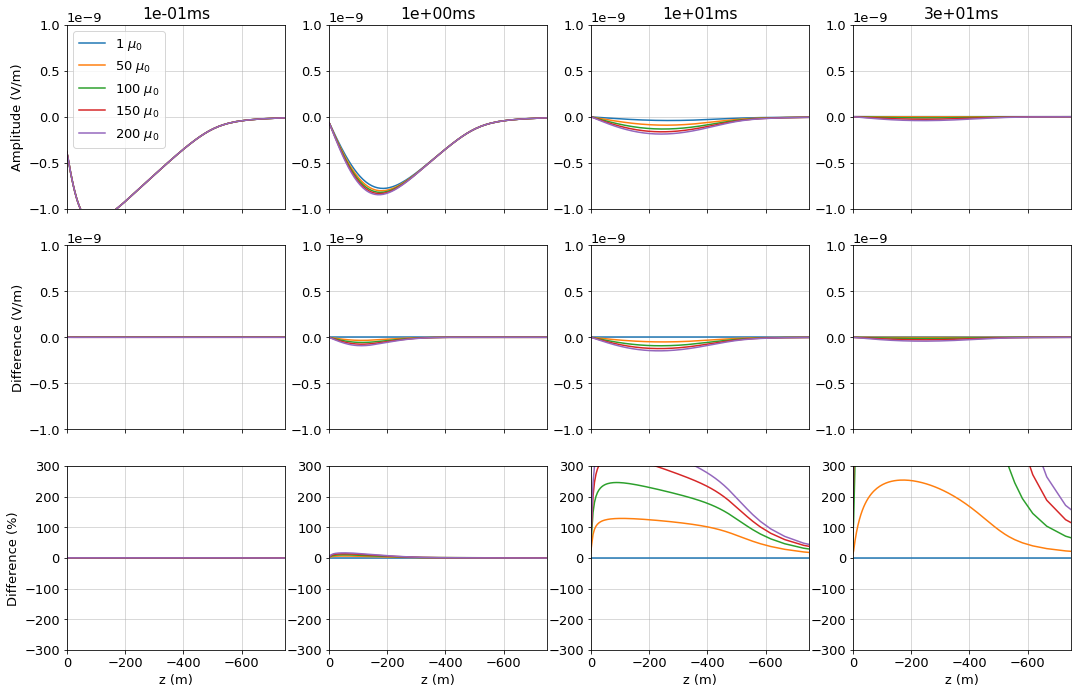

In [123]:
fig, ax = plt.subplots(3, len(tinds), figsize=(18, 11.5), sharex=True)

zlim = np.r_[0, -750]
spatial_inds = inds + mesh.n_cells
for i, it in enumerate(tinds):
    plot_cell_centered_data_space(
        cell_centered_b, ax[:, i], spatial_inds, it, keys=list(cell_centered_e.keys())[1:], primary_key="casing_1", 
        xlim=zlim, ylim=1e-9*np.r_[-1, 1], percent_lim=300*np.r_[-1, 1], eps=1e-17,
        labels=True if i==0 else False, legend=True if i==0 else False, 
    )
    ax[0, i].set_title(f"{times[it]*1e3:1.0e}ms")
ax[0, 0].legend()

In [199]:
fields

{'halfspace': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd258156eb0>,
 'casing_1': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd245cf45e0>,
 'casing_50': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd245ead340>,
 'casing_100': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd245ead550>,
 'casing_150': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd24548f370>,
 'casing_200': <SimPEG.electromagnetics.time_domain.fields.Fields3DMagneticField at 0x7fd245d7fd60>}

In [1147]:
f = fields["casing_150"]
sim = f.simulation

In [1148]:
b = f[:, "b", :]
j = f[:, "j", :]

In [1149]:
curl_b = mesh.edge_curl * b

In [1150]:
not_hanging_faces = np.hstack([
    ~getattr(mesh, f"_ishanging_faces_{coord}_bool") for coord in ["x", "y", "z"]
])

In [1151]:
not_hanging_edges = np.hstack([
    ~getattr(mesh, f"_ishanging_edges_{coord}_bool") for coord in ["x", "y", "z"]
])

In [1153]:
ave_fz2ey = discretize.utils.kron3(
    discretize.utils.speye(mesh.shape_faces_z[2]),
    discretize.utils.speye(mesh.shape_faces_z[1]),
    discretize.utils.av_extrap(mesh.shape_faces_z[0]),
)[~mesh._ishanging_edges_y_bool, :] #* mesh._deflation_matrix("Ey", as_ones=True).T

ave_fx2ey = discretize.utils.kron3(
    discretize.utils.av_extrap(mesh.shape_faces_x[2]),
    discretize.utils.speye(mesh.shape_faces_x[1]),
    discretize.utils.speye(mesh.shape_faces_x[0]),
) 

In [1154]:
# ln_mu_term = ( 
#     -(mesh._face_divergence_stencil.T * np.log(sim.mu / mu_0))[not_hanging_faces]
# )
ln_mu_term = ( discretize.utils.sdiag(mesh.area * (mesh.average_cell_to_face * (1./mesh.vol))) *  
    -(mesh._face_divergence_stencil.T * (np.log(sim.mu / mu_0)))[not_hanging_faces]
)

ln_mu_r = ln_mu_term[:mesh.n_faces_x]
# ln_mu_t = ln_mu_term[mesh.n_cells:2*mesh.n_cells]
ln_mu_z = ln_mu_term[np.sum(mesh.n_faces_per_direction[:2]):]

by = b[mesh.n_edges_x:np.sum(mesh.n_edges_per_direction[:2]), :]
cross_x = - discretize.utils.sdiag(ave_fz2ey * ln_mu_z) * by
# cross_y = discretize.utils.sdiag(ln_mu_z) * b_r - discretize.utils.sdiag(ln_mu_r) * b_z
cross_z = discretize.utils.sdiag(ave_fx2ey * ln_mu_r) * by



In [1165]:
b.shape

(612141, 317)

In [1155]:

# lnmur_cross_b = np.vstack([cross_x, cross_y, cross_z])
lnmu_cross_b = np.vstack([
    mesh.average_edge_y_to_cell * cross_x,
    np.zeros((mesh.n_cells, len(times))), 
    mesh.average_edge_y_to_cell * cross_z
])

In [1156]:
curl_b_cc = mesh.average_face_to_cell_vector * curl_b

In [1157]:
mu_j = (
    discretize.utils.sdiag(np.kron(np.ones(3), sim.mu)) * 
    mesh.average_face_to_cell_vector * j
)

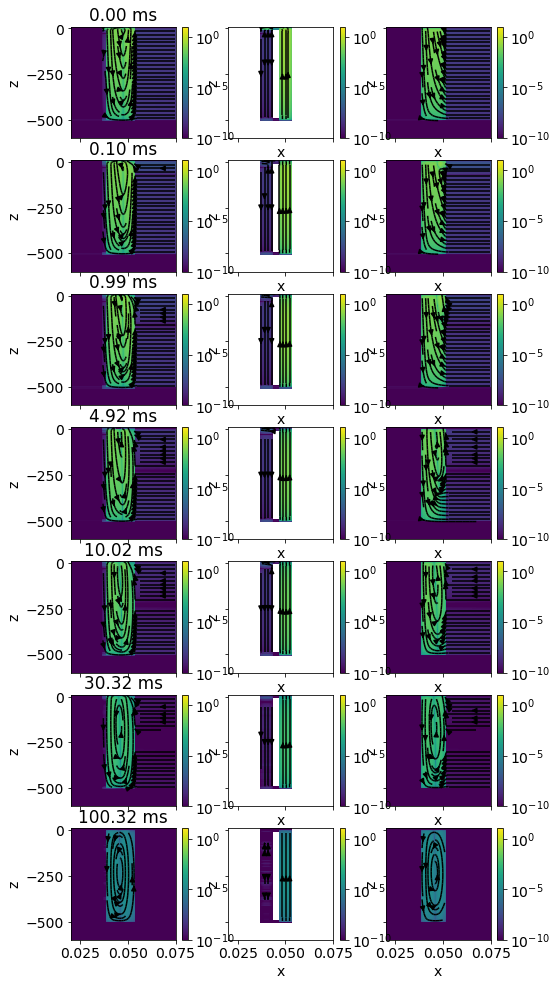

In [1158]:
fig, ax = plt.subplots(
    len(time_inds), 3, figsize=(8, (len(time_inds))*2.4),
    sharex=True, sharey=True
)

xlim = np.r_[0.02, 0.075]
zlim = np.r_[-600, 10]
clim = np.r_[1e-10, 1e1]

for i, ti in enumerate(time_inds):
    plot_cell_centered_vector(
        curl_b_cc[:, ti], 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        # curl_b_cc[:, ti] - mu_j[:, ti],
        lnmu_cross_b[:, ti], 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        mu_j[:, ti], 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    ax[i, 0].set_title(f"{times[ti]*1e3:1.2f} ms")
    ax[i, 0].set_xlabel("")

In [1159]:
np.max(curl_b_cc[:, ti] - mu_j[:, ti] - lnmu_cross_b[:, ti])

1.4142244895118432e-08

In [1160]:
MuI = discretize.utils.sdiag(np.kron(np.ones(3), 1./sim.mu))

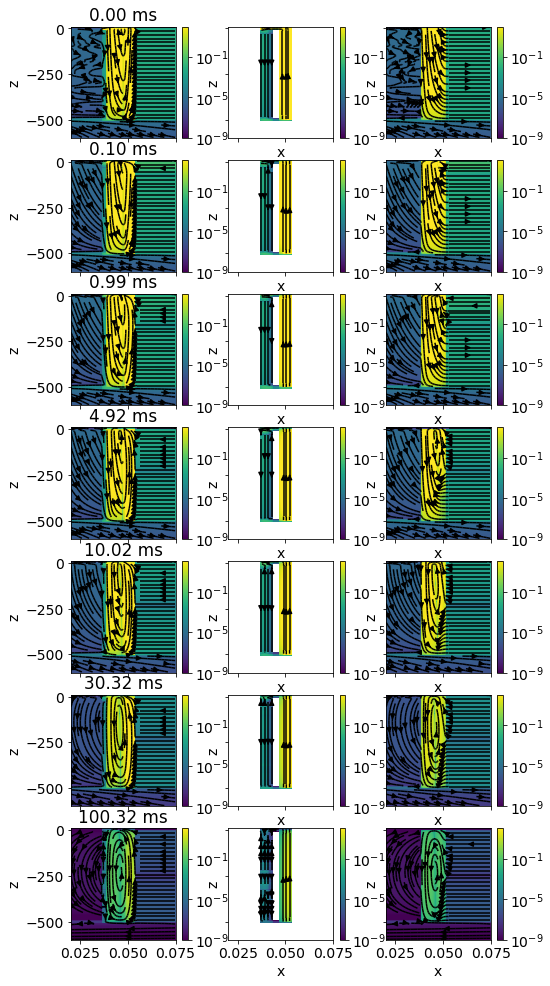

In [1161]:
fig, ax = plt.subplots(
    len(time_inds), 3, figsize=(8, (len(time_inds))*2.4),
    sharex=True, sharey=True
)

xlim = np.r_[0.02, 0.075]
zlim = np.r_[-600, 10]
clim = np.r_[1e-9, 1e2]

for i, ti in enumerate(time_inds):
    plot_cell_centered_vector(
        MuI * curl_b_cc[:, ti], 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        # MuI * (curl_b_cc[:, ti] - mu_j[:, ti]),
        MuI * lnmu_cross_b[:, ti], 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        MuI * mu_j[:, ti], 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    ax[i, 0].set_title(f"{times[ti]*1e3:1.2f} ms")
    ax[i, 0].set_xlabel("")

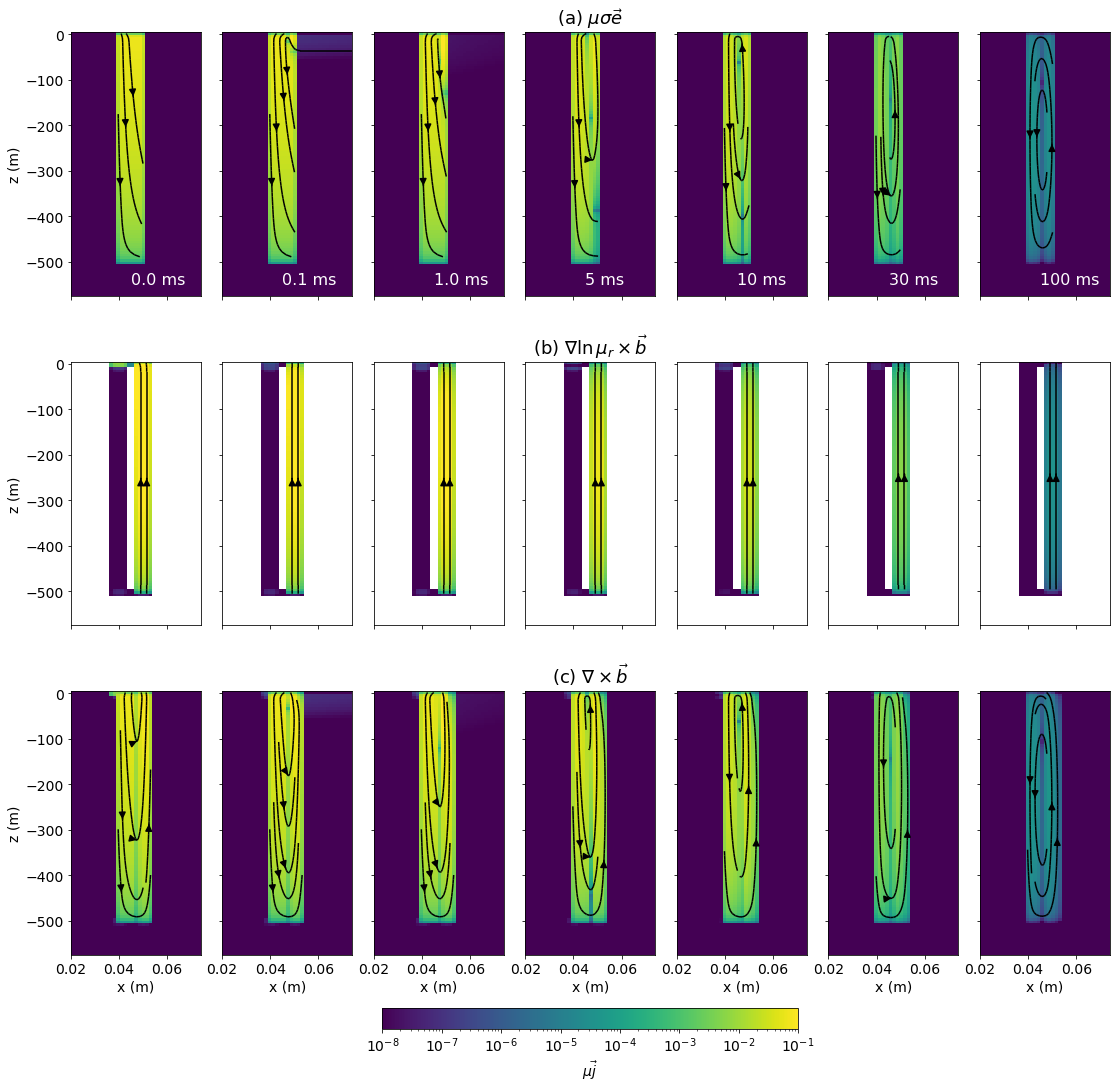

In [1256]:
fig, ax = plt.subplots(
    3, len(time_inds),
    figsize=(len(time_inds)*2.2, 15),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.02}
)

xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-8, 1e-1]

stream_opts= {"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

for j, ti in enumerate(time_inds):
    
    plot_cell_centered_vector(
        mu_j[:, ti], 
        theta_ind=3, ax=ax[0, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    
    plot_cell_centered_vector(
        # (curl_b_cc[:, ti] - mu_j[:, ti]),
        lnmu_cross_b[:, ti], 
        theta_ind=3, ax=ax[1, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    
    out = plot_cell_centered_vector(
        curl_b_cc[:, ti], 
        theta_ind=3, ax=ax[2, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    for i, a in enumerate(ax[:, j].flatten()):
        a.set_title("")
        a.set_xlim([0.02, 0.074])
        if j > 0: 
            a.set_ylabel("")
        else: 
            a.set_ylabel("z (m)")
        if i < 2:
            a.set_xlabel("")
        else:
            a.set_xlabel("x (m)")

    if times[ti] < 2e-3: 
        ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
    else: 
        ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("$\mu \\vec{j}$")

ax[0, 3].set_title("(a) $\mu \sigma \\vec{e}$", fontsize=18, pad=8)
ax[1, 3].set_title("(b) $\\nabla \ln \mu_r \\times \\vec{b}$", fontsize=18, pad=8)
ax[2, 3].set_title("(c) $\\nabla \\times \\vec{b}$", fontsize=18, pad=8)

if save_figures: 
    fig.savefig(f"{fig_dir_high}/magnetization-currents-casing", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/magnetization-currents-casing", dpi=dpi_low, bbox_inches="tight")

In [ ]:
def plot_cell_centered_vector(
    field_plot, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    log_scale=False, eps=1e-15, vmin=None, clim=None,
    component="both", show_colorbar=True,
    stream_opts=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)
    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    if component == "both" or component == "xz": 
        if component == "both":
            ax_xz = ax[0]
        else:
            ax_xz = ax
        # plot x,z vector
        fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
        fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

        vmax = clim.max() if clim is not None else None
        if log_scale is True: 
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else: 
            norm = Normalize(0, vmax)
        out = mesh2d.plot_image(
            fieldxz, v_type="CCv", view="vec", ax=ax_xz,
            range_x=xlim, range_y=zlim,
            sample_grid=sample_grid,
            mirror=True, mirror_data=fieldxz_mirror,
            pcolor_opts={"norm":norm},
            stream_threshold=vmin,
            stream_opts=stream_opts
        )
        if show_colorbar is True: 
            plt.colorbar(out[0], ax=ax_xz)


        pcolor_optsy = {"cmap":"Spectral_r"}
        linthresh = vmin if vmin is not None else eps

        if clim is None: 
            # vmin, vmax = np.max(np.abs(
            #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
            # ))*np.r_[-1, 1]
            vmin, vmax = norm.vmax*np.r_[-1, 1]
        else: 
            vmin = np.min(clim)
            vmax = np.max(clim)

        if log_scale is True:
            pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
        else: 
            pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    if component == "both" or component == "y": 
        if component == "both":
            ax_y = ax[1]
        else: 
            ax_y = ax
        out2 = mesh2d.plot_image(
            field_components["y"]["data"], ax=ax_y,
            mirror=True, mirror_data=field_components["y"]["mirror"],
            range_x=xlim, range_y=zlim, 
            pcolor_opts=pcolor_optsy
        )
        if show_colorbar is True: 
            plt.colorbar(out2[0], ax=ax_y)
    return out

In [ ]:
times[tinds_plot]*1e3

In [ ]:
tinds_plot

In [ ]:
fields.keys()

In [26]:
z_ind = 98
mesh.nodes_z[z_ind]

-104.99999999999869

In [ ]:
np.kron([1, 2, 3], [1, 1])

In [ ]:
def get_dedt(fields, ti):
    dhdt = fields[:, "dhdt", ti].squeeze()
    djdt = mesh.edge_curl * dhdt
    dedt = discretize.utils.sdiag(
        np.kron(np.ones(3), fields.simulation.rho)
    )* mesh.average_face_to_cell_vector * djdt
    return dedt

In [1071]:
def get_curl_curl_e(fields, ti):
    e = fields[:, "e", ti].squeeze()
    return mesh.average_face_to_cell_vector * mesh.edge_curl * mesh.edge_curl.T * e

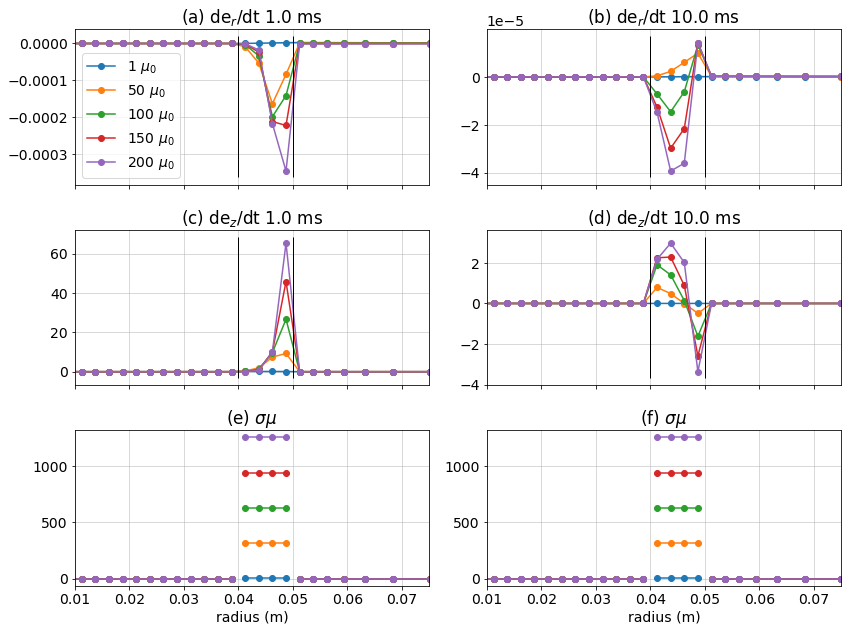

In [1072]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 98
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

# inds_plot_er = np.where(
#     (mesh.faces_x[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_x[:, 2] == mesh.cell_centers_z[z_ind])
# )[0] 

# inds_plot_ez = np.where(
#     (mesh.faces_z[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_z[:, 2] == mesh.nodes_z[z_ind])
# )[0] + np.sum(mesh.n_faces_per_direction[:2])

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)
inds_plot_er = np.where(inds_mu_plot)[0]
inds_plot_ez = np.where(inds_mu_plot)[0] + mesh.n_cells * 2

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        dedt = get_dedt(fields_plot, ti)
        sigmu = (fields_plot.simulation.sigma * fields_plot.simulation.mu)[inds_mu_plot]
        dedt_r = sigmu * dedt[inds_plot_er]
        dedt_z = sigmu * dedt[inds_plot_ez]
        
        ax[0, j].plot(mesh.cell_centers_x, dedt_r, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) de$_r$/dt {times[ti] *1e3:1.1f} ms")
        
        ax[1, j].plot(mesh.cell_centers_x, dedt_z, "-o", label=label)
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) de$_z$/dt {times[ti] *1e3:1.1f} ms")
        
        
        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[2, j].plot(x, sigmu[inds], "-o", color=f"C{i}", label=label) 
        ax[2, j].set_title(f"({ascii_lowercase[j+4]}) $\sigma \mu$")
        
    ax[0, 0].set_xlim(xlim)

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/induction-term", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/induction-term", dpi=dpi_low, bbox_inches="tight")

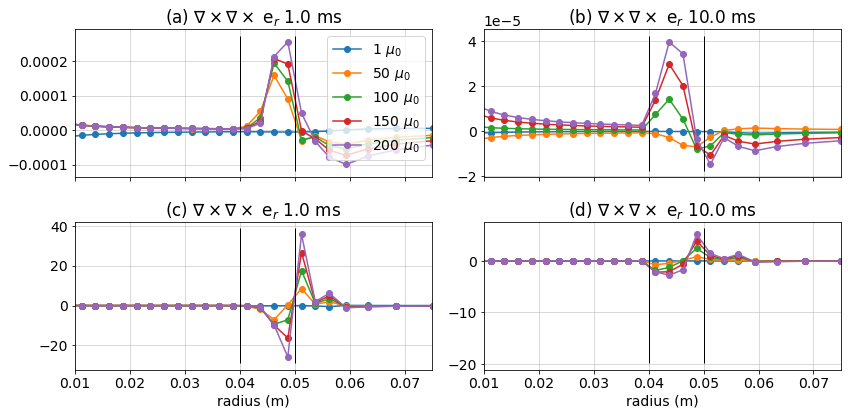

In [816]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 98
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(2, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 6))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

# inds_plot_er = np.where(
#     (mesh.faces_x[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_x[:, 2] == mesh.cell_centers_z[z_ind])
# )[0] 

# inds_plot_ez = np.where(
#     (mesh.faces_z[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_z[:, 2] == mesh.nodes_z[z_ind])
# )[0] + np.sum(mesh.n_faces_per_direction[:2])

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)
inds_plot_er = np.where(inds_mu_plot)[0]
inds_plot_ez = np.where(inds_mu_plot)[0] + mesh.n_cells * 2

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        curlcurle = get_curl_curl_e(fields_plot, ti)
        sigmu = (fields_plot.simulation.sigma * fields_plot.simulation.mu)[inds_mu_plot]
        curlcurle_r = curlcurle[inds_plot_er]
        curlcurle_z = curlcurle[inds_plot_ez]
        
        ax[0, j].plot(mesh.cell_centers_x, curlcurle_r, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) $\\nabla \\times \\nabla \\times$ e$_r$ {times[ti] *1e3:1.1f} ms")
        
        ax[1, j].plot(mesh.cell_centers_x, curlcurle_z, "-o", label=label)
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) $\\nabla \\times \\nabla \\times$ e$_r$ {times[ti] *1e3:1.1f} ms")
        
        
        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
        
    ax[0, 0].set_xlim(xlim)

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[-1, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/induction-term", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/induction-term", dpi=dpi_low, bbox_inches="tight")

In [901]:
mesh.nodes_z[99]

-99.99999999999869

/tmp/ipykernel_33643/812877095.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, j].set_yticklabels(["", "", "", "0", "", ""])


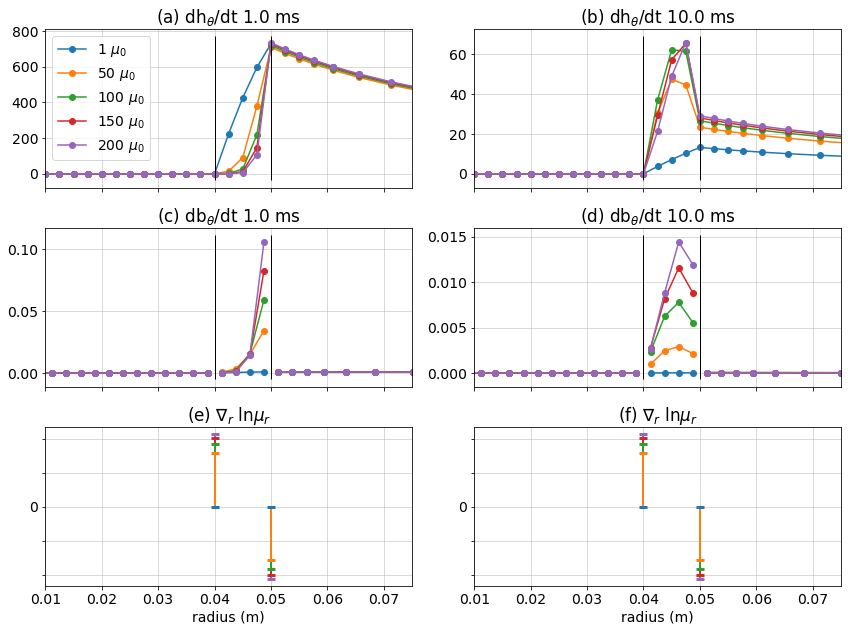

In [902]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 99
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

inds_plot = np.where(
    (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.edges_y[:, 2] == mesh.nodes_z[z_ind])
)[0] + mesh.n_edges_x 

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)

avx = discretize.utils.av(len(mesh.nodes_x[1:]))

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        # b = fields_plot[src_plot, "b"][inds_plot]
        dhdt = fields_plot[:, "dhdt", ti][inds_plot].squeeze()
        dhdtc = avx * np.hstack([np.r_[0], dhdt])
        dbdtc = fields_plot.simulation.mu[inds_mu_plot] * dhdtc
        # bc = discretize.utils.av(mesh.nodes

        ax[0, j].plot(mesh.nodes_x[1:], dhdt, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) dh$_\\theta$/dt {times[ti] *1e3:1.1f} ms")

        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[1, j].plot(x, dbdtc[inds].real, "-o", color=f"C{i}", label=label)
        
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) db$_\\theta$/dt {times[ti] *1e3:1.1f} ms")
    
    ax[0, 0].set_xlim(xlim)

for j in range(2): 
    for i, mur in enumerate(np.flipud(mur_plot)):
        divlogmur = np.log(mur)
        for x, posneg in zip([casing_a, casing_b], [1, -1]):
            ax[2, j].plot(np.r_[x, x], np.r_[0, posneg]*divlogmur, lw=2, color=f"C{4-i}")
            ax[2, j].plot(x, posneg*divlogmur, "_", color=f"C{4-i}", ms=8, markeredgewidth=3)
        ax[2, j].set_yticklabels(["", "", "", "0", "", ""])
        ax[2, j].set_title(f"({ascii_lowercase[4+j]}) $\\nabla_r$ ln$\mu_r$")

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/magnetization-term", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/magnetization-term", dpi=dpi_low, bbox_inches="tight")

/tmp/ipykernel_33643/3969011407.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, j].set_yticklabels(["", "", "", "0", "", ""])


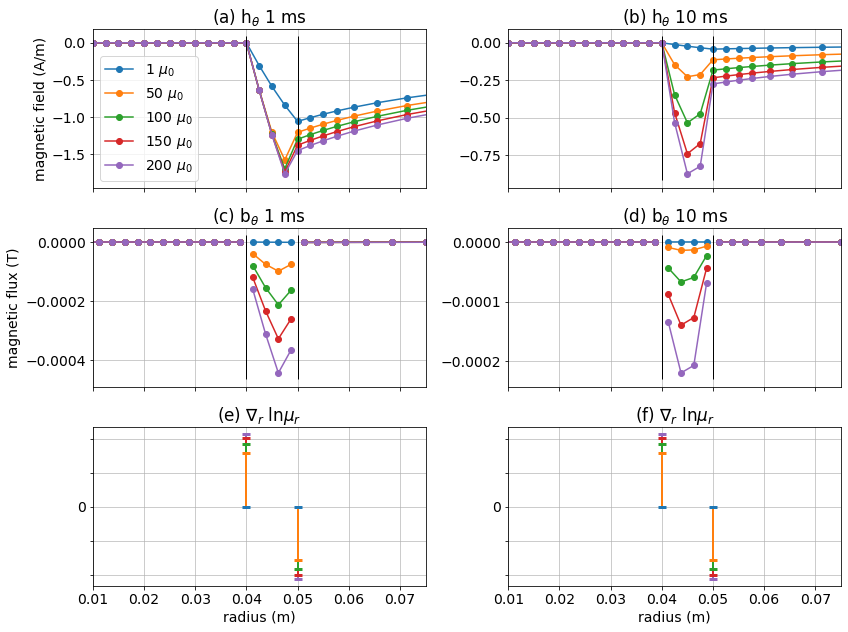

In [1261]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 99
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

inds_plot = np.where(
    (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.edges_y[:, 2] == mesh.nodes_z[z_ind])
)[0] + mesh.n_edges_x 

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)

avx = discretize.utils.av(len(mesh.nodes_x[1:]))

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        # b = fields_plot[src_plot, "b"][inds_plot]
        h = fields_plot[:, "h", ti][inds_plot].squeeze()
        hc = avx * np.hstack([np.r_[0], h])
        bc = fields_plot.simulation.mu[inds_mu_plot] * h
        # bc = discretize.utils.av(mesh.nodes

        ax[0, j].plot(mesh.nodes_x[1:], h, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) h$_\\theta$ {times[ti] *1e3:1.0f} ms")

        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[1, j].plot(x, bc[inds].real, "-o", color=f"C{i}", label=label)
        
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) b$_\\theta$ {times[ti] *1e3:1.0f} ms")
    
    ax[0, 0].set_xlim(xlim)

for j in range(2): 
    for i, mur in enumerate(np.flipud(mur_plot)):
        divlogmur = np.log(mur)
        for x, posneg in zip([casing_a, casing_b], [1, -1]):
            ax[2, j].plot(np.r_[x, x], np.r_[0, posneg]*divlogmur, lw=2, color=f"C{4-i}")
            ax[2, j].plot(x, posneg*divlogmur, "_", color=f"C{4-i}", ms=8, markeredgewidth=3)
        ax[2, j].set_yticklabels(["", "", "", "0", "", ""])
        ax[2, j].set_title(f"({ascii_lowercase[4+j]}) $\\nabla_r$ ln$\mu_r$")

for a in ax.flatten():
    a.grid("both", alpha=0.8)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()

ax[0, 0].set_ylabel("magnetic field (A/m)")
ax[1, 0].set_ylabel("magnetic flux (T)")

for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/magnetization-term", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/magnetization-term", dpi=dpi_low, bbox_inches="tight")

In [481]:
faces_z_casing = (
    (mesh.faces_z[:, 0] >= casing_a) & (mesh.faces_z[:, 0] <= casing_b) &
    (mesh.faces_z[:, 2] >= -casing_l) & (mesh.faces_z[:, 2] <= 0)
)

In [528]:
total_casing_currents = {}
for key, f in fields.items():
    jz = f[:, "j", :][np.sum(mesh.n_faces_per_direction[:2]):, :]
    Iz = discretize.utils.sdiag(mesh.face_z_areas * faces_z_casing) * jz
    total_casing_currents[key] = Iz

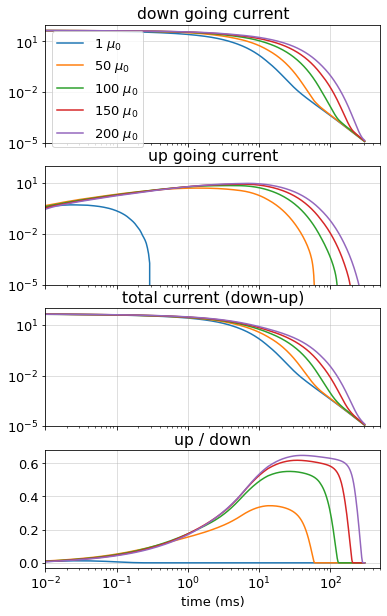

In [539]:
fig, ax = plt.subplots(4, 1, figsize=(6, 10), sharex=True)

for i, mur in enumerate(mur_casing):
    key = f"casing_{mur}" 
    
    Iz = total_casing_currents[key]
    
    Iz_pos = Iz * (Iz > 0)
    Iz_neg = Iz * (Iz < 0)

    ax[0].loglog(times*1e3, -Iz_neg.sum(0), color=f"C{i}", label=f"{mur} $\mu_0$")
    ax[1].loglog(times*1e3, Iz_pos.sum(0), f"C{i}")
    ax[2].loglog(times*1e3, -Iz.sum(0))
    ax[3].semilogx(times*1e3, Iz_pos.sum(0)/-Iz_neg.sum(0), label=f"{mur} $\mu_0$")

ax[0].set_title("down going current")
ax[1].set_title("up going current")
ax[2].set_title("total current (down-up)")
ax[3].set_title("up / down") 
ax[3].set_xlabel("time (ms)")
ax[0].legend()

ylim = np.r_[1e-5, 1e2]
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim)

ax[0].set_xlim([1e-2, 5e2])

for a in ax:
    a.grid("both", alpha=0.5)

In [1166]:
edges_theta_casing = (
    (mesh.edges_y[:, 0] >= casing_a)  & (mesh.edges_y[:, 0] <= casing_b) &
    (mesh.edges_y[:, 2] >= -casing_l) & (mesh.edges_y[:, 2] <= 0)
)

In [1167]:
fields.keys()

dict_keys(['halfspace', 'casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200'])

In [1205]:
casing_dhdt = {}
for key, f in fields.items():
    dhdt = f[:, "dhdt", :][mesh.n_edges_x:np.sum(mesh.n_edges_per_direction[:2]), :]
    dhdt_casing = discretize.utils.sdiag(edges_theta_casing) * dhdt
    casing_dhdt[key] = dhdt_casing

In [ ]:
# casing_dbdt_avg = {}
# n_edges = edges_theta_casing.reshape(mesh.shape_edges_y, order="F").sum(0).sum(0)

# for key, val in casing_dbdt.items():
#     dbdt = casing_dbdt[key]
    

In [1173]:
outer_face_val = np.min(np.abs(mesh.nodes_x - casing_b))

In [1175]:
radial_faces_casing = (
    (np.abs(mesh.faces_x[:, 0] - casing_b) == outer_face_val) &
    (mesh.faces_x[:, 2] >= -casing_l) & (mesh.faces_x[:, 2] <= 0)
)

In [1211]:
casing_Ix = {}
for key, f in fields.items():
    jx = f[:, "j", :][:mesh.n_faces_x, :]
    jx_casing = discretize.utils.sdiag(radial_faces_casing) * jx
    casing_Ix[key] = jx_casing

In [1228]:
tinds_plot

[0, 53, 109, 152, 169, 197, 227]

In [1231]:
times[tinds_plot]*1e3

array([ 0.   ,  0.099,  0.99 ,  4.92 , 10.02 , 30.32 , 60.32 ])

In [1232]:
tinds_plot_subset = [53, 109, 169]

/tmp/ipykernel_33643/2802327996.py:17: RuntimeWarning: invalid value encountered in true_divide
  avg_dhdt = tmp/avg_edges


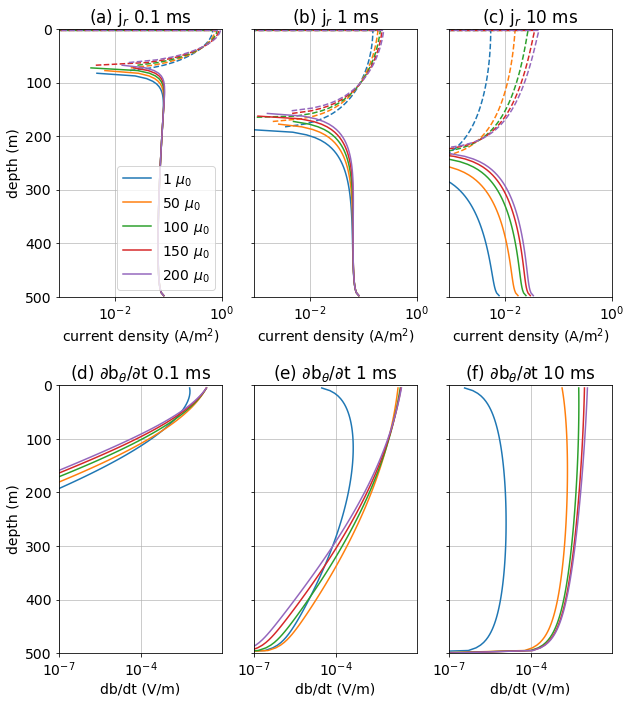

In [1259]:
fig, ax = plt.subplots(2, len(tinds_plot_subset), figsize=(len(tinds_plot_subset)*3, 10), sharey=True)


for i, mur in enumerate(mur_casing):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    for j, ti in enumerate(tinds_plot_subset): 
        ix = casing_Ix[key][:, ti].reshape(mesh.shape_faces_x, order="F").sum(0).sum(0)
        plot_pos_neg_log(-mesh.cell_centers_z, ix, ax[0, j], "semilogx", color=f"C{i}", label=label, invert_axes=True)
        
        # ax[0, j].plot(ix, mesh.cell_centers_z, color=f"C{i}", label=label)

        
        tmp = (mesh.edge_y_lengths * casing_dhdt[key][:, ti]).reshape(mesh.shape_edges_y, order="F").sum(1).mean(0) 
        avg_edges = (mesh.edge_y_lengths * edges_theta_casing).reshape(mesh.shape_edges_y, order="F").sum(1).mean(0)
        avg_dhdt = tmp/avg_edges
        avg_dbdt = avg_dhdt * mur*mu_0
        
        plot_pos_neg_log(-mesh.nodes_z, avg_dbdt, ax[1, j], "semilogx", color=f"C{i}", label=label, invert_axes=True)
    
        if times[ti]*1e3 <= 0.99:
            ax[0, j].set_title(f"({ascii_lowercase[j]}) j$_r$ {times[ti] *1e3:1.1f} ms")
            ax[1, j].set_title(f"({ascii_lowercase[j+3]}) $\\partial$b$_\\theta$/$\\partial$t {times[ti] *1e3:1.1f} ms")
        else:
            ax[0, j].set_title(f"({ascii_lowercase[j]}) j$_r$ {times[ti] *1e3:1.0f} ms")
            ax[1, j].set_title(f"({ascii_lowercase[j+3]}) $\\partial$b$_\\theta$/$\\partial$t {times[ti] *1e3:1.0f} ms")

ax[0, 0].set_ylim([500, 0])
ax[0, 0].set_ylabel("depth (m)")
ax[1, 0].set_ylabel("depth (m)")
for a in ax[0, :]:
    a.grid("both", alpha=0.8)
    a.set_xlim([9e-4, 1e0])
    a.set_xlabel("current density (A/m$^2$)")
    

for a in ax[1, :]:
    a.grid("both", alpha=0.8)
    a.set_xlim([1e-7, 9e-2])
    a.set_xlabel("db/dt (V/m)")
    
ax[0, 0].legend(loc=4)

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/permeability-contributions", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/permeability-contributions", dpi=dpi_low, bbox_inches="tight")